# Tier coding challenge

This script converts raw sessions data into sessions table. SQL was the pre-dominant languge used but within pandasql package due to ease of setting up and importing data. The scope of this script is as follows:

1. Transform raw data from the app into sessions table using SQL code
2. Basic insights from the sessions table



### Key assumptions
- The data is related to only escooters (not the coup scooters).
- It is highly unlikely that the time difference between two actions will be longer than 30 minutes.
- Session is, therefore, defined using a maximum inactive time of 30 minutes between actions.
- Each customer can redeem one code per booking.

### Summary

- <b style="color:green;">Insight 1:</b> Average length of a session is 500 seconds ~ 8 minutes
- <b style="color:green;">Insight 2:</b> Average number of sessions per user is ~1.5
- <b style="color:green;">Insight 3:</b> Average time from session start to booking is 328 seconds ~ 5.5 minutes
- <b style="color:green;">Insight 4:</b> 72% of users were looking for a scooter in one or more sessions.
- <b style="color:green;">Insight 5:</b> 12% of users who were looking for a scooter could not book one.
- <b style="color:green;">Insight 6:</b> 64% of sessions were when users were looking for a scooter.
- <b style="color:green;">Insight 7:</b> 6% of sessions when looking for a scooter, booking failed.
- <b style="color:green;">Insight 8:</b> Probability of booking scooter highest between 1 and 3 pm.
- <b style="color:green;">Insight 9:</b> Signup completion rate is 255/450 ~ 57%
- <b style="color:green;">Insight 10:</b> 811 out of 8629 customers declined rating their experience/app.
- <b style="color:green;">Insight 11:</b> 511 customers redeemed code 539 times. Some customers had access to more than 1 code. It could be employees but there is a chance that code have been mis-used (open forum sharing).


### Ideas for further insights

1. Distribution of reasons behind users failing to book a scooter - Is there a leading cause?
2. Number of times users played sound from vehicle - Indication of how accurate is the scooter location on app?
3. Repeat rates from customers - A good measure of customer confidence in service.
4. Funnel tracking - From signup to booking the app scooter, how does the app interactions breakdown look like? Where is the highest abandonment rate?
4. Predicting booking scooter using session events - One hot encoding of all events per customer and user session id  will create features for the classification model. Accuracy of classification is expected to be low due to limited data. Also the dataset is unbalanced (higher number of bookings), therefore, precision could be low. Tree based ensemble model would be a good choice for this prediction.


### Requirements to run this script
1. Ensure that the Python version is 3.0 or higher
2. Install pandasql using conda/pip (package uses SQLite syntax)

## 1. Transforming raw data into sessions table

### Step 1: Importing file

In [34]:
# importing the required modules
from pandasql import sqldf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
sns.set_style("darkgrid")

# loading raw data 
df = pd.read_csv('downloads/TIER DATA CHALLENGE/mobile_events.csv')

In [35]:
df.head()

,anonymous_id,business_zoned,context_app_version,context_device_id,context_os_name,event_name,received_at,created_at
0,9DDC5BCD-0477-4E83-A32A-51013DA0A4E7,Hamburg,3.1.13,7A718FF6-584F-40E2-939D-224231295B1E,iOS,Out-Of-Business Zone View Shown,2019-09-01 23:59:44,2019-09-01 23:59:18
1,5592E78E-CE87-4258-B8D7-DD834A687A1E,Hamburg,3.1.13,11D0CB16-DA38-4565-9C3B-066E7877856C,iOS,Application Opened,2019-09-01 23:59:41,2019-09-01 23:59:35
2,5592E78E-CE87-4258-B8D7-DD834A687A1E,Hamburg,3.1.13,11D0CB16-DA38-4565-9C3B-066E7877856C,iOS,Ride Done - Successful,2019-09-01 23:59:41,2019-09-01 23:59:37
3,5592E78E-CE87-4258-B8D7-DD834A687A1E,Hamburg,3.1.13,11D0CB16-DA38-4565-9C3B-066E7877856C,iOS,Application Opened,2019-09-01 23:59:36,2019-09-01 23:37:46
4,5592E78E-CE87-4258-B8D7-DD834A687A1E,Hamburg,3.1.13,11D0CB16-DA38-4565-9C3B-066E7877856C,iOS,Ride Done - Unsuccessful,2019-09-01 23:59:36,2019-09-01 23:37:52


In [8]:
# All the event names in this table
df.event_name.sort_values().unique()

array(['Account Setup Opened', 'Add Payment Method', 'Application Opened',
       'Application Updated', 'Credit Card Details Accepted',
       'Credit Card Details Rejected',
       'Customer Blocked - Phone Validation', 'Help - Booking',
       'Help - Sidebar', 'Layover - Tier Not Available Yet',
       'List Of Payment Shown', 'Location Services Dialogue Opened',
       'Location Services Enabled', 'Map Legend Clicked',
       'No-Parking View Shown', 'Out-Of-Business Zone View Shown',
       'Payment Details Screen Opened', 'Payment Method Chosen',
       'Payment Method Screen Opened', 'Payment Opened',
       'Paypal Added Successfully', 'Paypal Cancelled',
       'Paypal Dialogue - Cancel Pressed',
       'Paypal Dialogue - Okay Pressed', 'Paypal Dialogue Shown',
       'Paypal Error Shown', 'Personal Details Added Succeeded',
       'Phone Number Blocked - Phone Validation', 'Phone Number Entered',
       'Play Sound From Scooter', 'Play Sound From Vehicle',
       'Qr Scanner

### Step 2 : Writing subqueries for transformation 

In [9]:
# subquery last - extracting last action by user
sqldf('''
select 
    anonymous_id,
    datetime(created_at) as created_at,
    lag(datetime(created_at),1) over(partition by anonymous_id order by datetime(created_at)) as last_event
from df
''')

,anonymous_id,created_at,last_event
0,001737b7-bfca-4486-808c-ad876c28406b,2019-08-31 21:38:50,None
1,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:40,2019-08-31 21:38:50
2,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:48,2019-09-01 16:26:40
3,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:56,2019-09-01 16:26:48
4,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:27:00,2019-09-01 16:26:56
...,...,...,...
102417,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:37,2019-09-01 16:31:29
102418,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:45,2019-09-01 16:31:37
102419,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:01,2019-09-01 16:31:45
102420,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:43,2019-09-01 16:40:01


In [10]:
# subquery final - If time between two consecutive actions in more than 30 minutes then code as new session
sqldf('''
select
    *,
    case when strftime('%s',created_at) - strftime('%s',last_event) >= (30*60) 
           or last_event is NULL 
         then 1 else 0 end as is_new_session
from(
    select 
        anonymous_id,
        datetime(created_at) as created_at,
        lag(datetime(created_at),1) over(partition by anonymous_id order by datetime(created_at)) as last_event
    from df
    ) as last

''')

,anonymous_id,created_at,last_event,is_new_session
0,001737b7-bfca-4486-808c-ad876c28406b,2019-08-31 21:38:50,None,1
1,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:40,2019-08-31 21:38:50,1
2,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:48,2019-09-01 16:26:40,0
3,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:56,2019-09-01 16:26:48,0
4,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:27:00,2019-09-01 16:26:56,0
...,...,...,...,...
102417,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:37,2019-09-01 16:31:29,0
102418,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:45,2019-09-01 16:31:37,0
102419,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:01,2019-09-01 16:31:45,0
102420,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:43,2019-09-01 16:40:01,0


In [11]:
# Creating global and user session ids
sqldf('''

select
    anonymous_id,
    created_at,
    SUM(is_new_session) OVER (ORDER BY anonymous_id, created_at) AS global_session_id,
    SUM(is_new_session) OVER (PARTITION BY anonymous_id ORDER BY created_at) AS user_session_id
from(
    select
        *,
        case when strftime('%s',created_at) - strftime('%s',last_event) >= (30*60) 
               or last_event is NULL 
             then 1 else 0 end as is_new_session
    from(
        select 
            anonymous_id,
            datetime(created_at) as created_at,
            lag(datetime(created_at),1) over(partition by anonymous_id order by datetime(created_at)) as last_event
        from df
        ) as last -- adding new timestamp column storing last action timestamp
    ) as final -- using the 30 minute threshold to define sessions
''')

,anonymous_id,created_at,global_session_id,user_session_id
0,001737b7-bfca-4486-808c-ad876c28406b,2019-08-31 21:38:50,1,1
1,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:40,2,2
2,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:48,2,2
3,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:26:56,2,2
4,001737b7-bfca-4486-808c-ad876c28406b,2019-09-01 16:27:00,2,2
...,...,...,...,...
102417,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:37,13284,2
102418,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:31:45,13284,2
102419,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:01,13284,2
102420,ffeeb3b6-7590-4395-8bad-d544dce5699f,2019-09-01 16:40:43,13284,2


### Step 4 : Bringing it all together with customer intent 

In [12]:
# bringing all subqueries together into sessions data
sessions_data = sqldf('''
with
session_id as 
(

    select
        anonymous_id,
        created_at,
        SUM(is_new_session) OVER (ORDER BY anonymous_id, created_at) AS global_session_id,
        SUM(is_new_session) OVER (PARTITION BY anonymous_id ORDER BY created_at) AS user_session_id
    from(
        select
            *,
            case when strftime('%s',created_at) - strftime('%s',last_event) >= (30*60) 
                   or last_event is NULL 
                 then 1 else 0 end as is_new_session
        from(
            select 
                anonymous_id,
                datetime(created_at) as created_at,
                lag(datetime(created_at),1) over(partition by anonymous_id order by datetime(created_at)) as last_event
            from df
            ) as last -- adding new timestamp column storing last action timestamp
        ) as final -- using the 30 minute threshold to define sessions

)


select
    *
from df
join session_id using (anonymous_id,created_at) -- joining data to df to get all data in a single table
order by 1,8
''')

In [13]:
# coding intent of looking for scooter and booking scooter successfully
intent = sqldf('''
select
    anonymous_id,
    user_session_id,
    max(case when event_name like '%Scooter Selected%'
           or event_name like '%Vehicle Selected%'
         then 1 else 0 end) as looking_for_scooter,
    max(case when event_name like '%Ride Started - Successful%'
         then 1 else 0 end) as booked_scooter
from sessions_data
group by 1,2
''')

# Joining intent with sessions data to create sessions_table
sessions_table = pd.merge(sessions_data,intent,on = ['anonymous_id','user_session_id'])

In [14]:
# Visual QA to check table entries are organised as expected
sessions_table.head(20)

,anonymous_id,business_zoned,context_app_version,context_device_id,context_os_name,event_name,received_at,created_at,global_session_id,user_session_id,looking_for_scooter,booked_scooter
0,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Map Legend Clicked,2019-09-01 16:27:10,2019-08-31 21:38:50,1,1,0,0
1,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Application Opened,2019-09-01 16:27:10,2019-09-01 16:26:40,2,2,1,0
2,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - Auto,2019-09-01 16:27:10,2019-09-01 16:26:48,2,2,1,0
3,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - User,2019-09-01 16:27:10,2019-09-01 16:26:56,2,2,1,0
4,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - User,2019-09-01 16:27:10,2019-09-01 16:27:00,2,2,1,0
5,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - User,2019-09-01 16:27:10,2019-09-01 16:27:03,2,2,1,0
6,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - User,2019-09-01 16:27:10,2019-09-01 16:27:06,2,2,1,0
7,001737b7-bfca-4486-808c-ad876c28406b,Hamburg,3.1.12,001737b7-bfca-4486-808c-ad876c28406b,Android,Vehicle Selected - User,2019-09-01 16:27:10,2019-09-01 16:27:08,2,2,1,0
8,00279F2D-30A6-43C7-9D9F-7A6BFE0E29D3,Hamburg,3.1.13,9ABC233D-157C-488D-90E4-D3207F82BCA1,iOS,Application Opened,2019-09-01 21:22:28,2019-09-01 21:21:57,3,1,0,0
9,0042A4AC-A2D9-414E-B857-19A74A130972,Hamburg,3.1.13,BCFCFCF9-6693-4C5B-939F-1FB40749783D,iOS,Application Opened,2019-09-01 13:54:16,2019-09-01 13:53:54,4,1,1,1


## 2. Insights

In [15]:
# customer level summary
sqldf(''' 

with
counter as 
(
    select
        count(distinct(anonymous_id)) as total_customers
    from sessions_table
)

, status as
(
    select
        'Looking for scooter' as status,
        count(distinct(anonymous_id)) as num_customers
    from sessions_table
    where 1=1
      and event_name like '%Scooter Selected%' -- Android
       or event_name like '%Vehicle Selected%' -- IOS
    group by 1

    union

    select
        'Ride booking successful' as status,
        count(distinct(anonymous_id)) as num_customers
    from sessions_table
    where 1=1
      and event_name like '%Ride Started - Successful%'
    group by 1

    union

    select
        'Ride finished successful' as status,
        count(distinct(anonymous_id)) as num_customers
    from sessions_table
    where 1=1
      and event_name like '%Ride Done - Successful%'
    group by 1

    union

    select
        'Ride booking failed' as status,
        count(distinct(anonymous_id)) as num_customers
    from sessions_table
    where 1=1
      and event_name like '%Ride Started - Unsuccessful%'
      and event_name not like '%Ride Started - Successful%'
       or event_name like '%Ride Cancelled%'
    group by 1
    
    union

    select
        'Ride finished unsuccessful' as status,
        count(distinct(anonymous_id)) as num_customers
    from sessions_table
    where 1=1
      and event_name like '%Ride Done - Unsuccessful%'
    group by 1
)

select
    *,
    (num_customers * 100/total_customers) as pct_customers
from status
cross join counter
''')

,status,num_customers,total_customers,pct_customers
0,Looking for scooter,6241,8629,72
1,Ride booking failed,525,8629,6
2,Ride booking successful,3413,8629,39
3,Ride finished successful,3500,8629,40
4,Ride finished unsuccessful,76,8629,0


In [16]:
# session level summary
sqldf(''' 

with
counter as 
(
    select
        count(distinct(global_session_id)) as total_sessions
    from sessions_table
)

, status as
(
    select
        'Looking for scooter' as status,
        count(distinct(global_session_id)) as num_sessions
    from sessions_table
    where 1=1
      and event_name like '%Scooter Selected%' -- Android
       or event_name like '%Vehicle Selected%' -- IOS
    group by 1

    union

    select
        'Ride booking successful' as status,
        count(distinct(global_session_id)) as num_sessions
    from sessions_table
    where 1=1
      and event_name like '%Ride Started - Successful%'
    group by 1

    union

    select
        'Ride finished successful' as status,
        count(distinct(global_session_id)) as num_sessions
    from sessions_table
    where 1=1
      and event_name like '%Ride Done - Successful%'
    group by 1

    union

    select
        'Ride booking failed' as status,
        count(distinct(global_session_id)) as num_sessions
    from sessions_table
    where 1=1
      and event_name like '%Ride Started - Unsuccessful%'
      and event_name not like '%Ride Started - Successful%'
       or event_name like '%Ride Cancelled%'
    group by 1
    
    union

    select
        'Ride finished unsuccessful' as status,
        count(distinct(global_session_id)) as num_sessions
    from sessions_table
    where 1=1
      and event_name like '%Ride Done - Unsuccessful%'
    group by 1
)

select
    *,
    (num_sessions * 100/total_sessions) as pct_sessions
from status
cross join counter
''')

,status,num_sessions,total_sessions,pct_sessions
0,Looking for scooter,8510,13285,64
1,Ride booking failed,563,13285,4
2,Ride booking successful,4319,13285,32
3,Ride finished successful,4515,13285,33
4,Ride finished unsuccessful,78,13285,0


In [18]:
# average length of a session
sqldf('''
select 
    count(*) AS sessions,
    avg(length) AS average_session_length
from(
    select 
        global_session_id,
        strftime('%s',max(created_at)) - strftime('%s',min(created_at)) AS length
    from sessions_data
    group by 1
    )
''')

,sessions,average_session_length
0,13285,500.266165


In [19]:
# average time to booking
sqldf('''
with
start_ts as
(
    select
        global_session_id,
        strftime('%s',min(created_at)) as start
    from sessions_data
    group by 1
),

booked_ts as
(
    select
        global_session_id,
        strftime('%s',created_at) as booked
    from sessions_data
    where 1=1
      and event_name like '%Ride Started - Successful%'
    group by 1
)

select
    avg(booked-start) as avg_time_to_book
from start_ts
join booked_ts
using (global_session_id)
''')

,avg_time_to_book
0,328.873582


In [20]:
# average number of sessions per user
sqldf('''
select 
    avg(sessions) AS average_session_per_user
from(
    select 
        distinct(anonymous_id),
        count(distinct(user_session_id)) AS sessions
    from sessions_data
    group by 1
    )
''')

,average_session_per_user
0,1.539576


Text(0.5, 0, 'Hour of Day')

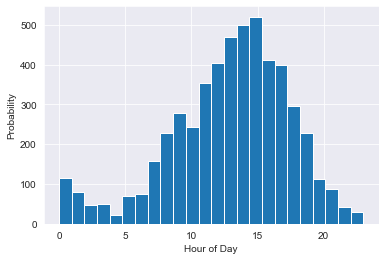

In [21]:
# distribution of bookings based on time of day

# converting column to datetime
sessions_data.created_at = pd.to_datetime(sessions_data.created_at)

# making a copy of sessions_data with timestamps where a scooter is booked
temp = sessions_data[sessions_data.event_name == 'Ride Started - Successful'].copy()

# Plotting the distribution
plt.hist(temp.created_at.dt.hour, bins=24)
plt.ylabel('Probability')
plt.xlabel('Hour of Day')

In [23]:
# number of customer who started and completed signups
sqldf('''
    select 
        count(distinct case when event_name like '%Signup Started%'
                            then anonymous_id else null end) AS signups_started,
        count(distinct case when event_name like '%Signup Completed%'
                            then anonymous_id else null end) AS signups_completed
    from sessions_data
''')

,signups_started,signups_completed
0,450,255


In [30]:
# number of customers and sessions where a code was redeemed
sqldf('''
    select 
        count(distinct case when event_name like '%Redeem Code%'
                            then global_session_id else null end) AS sessions_codes_redeemed,
        count(distinct case when event_name like '%Redeem Code%'
                            then anonymous_id else null end) AS customers_codes_redeemed
    from sessions_data
''')

,sessions_codes_redeemed,customers_codes_redeemed
0,539,511


In [31]:
sqldf('''
    select 
        count(distinct case when event_name like '%Rating Screen Closed - Maybe Later%'
                              or event_name like '%Rating Screen Closed - Not Interested%'
                            then anonymous_id else null end) AS customers_declined_rating
    from sessions_data
''')

,customers_declined_rating
0,817
